# Imports and Data Cleaning

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
from operator import itemgetter
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

conn = sqlite3.connect('../../Data/Experiment_4/exp4_localData.db')
dat = pd.read_sql('SELECT * FROM subjects WHERE complete=1', con=conn)
# forgot to remove non-prolific test runs, so I'll remove rows where prolific_id is a random float
dat = dat[[pp.isalnum() for pp in dat.prolific_id.values]]
# Setting some variables about the specifics of the stimulus
dat['agent'] = 'inanimate'
dat['patient'] = 'inanimate'
dat.loc[(dat.stim1 == 'anim_v1.mp4') & (dat.stim2 == 'y_p_v2.mp4'), 'agent'] = 'animate'
dat.loc[(dat.stim1 == 'anim_v1.mp4') & (dat.stim2 == 'p_y_v2.mp4'), 'patient'] = 'animate'
dat.loc[(dat.agent=='animate') & (dat.patient == 'inanimate'), 'condition'] = 'anim agent/phys patient'
dat.loc[(dat.agent=='inanimate') & (dat.patient == 'inanimate'), 'condition'] = 'phys agent/phys patient'
dat.loc[(dat.agent=='inanimate') & (dat.patient == 'animate'), 'condition'] = 'phys agent/anim patient'
ordering = ['phys agent/phys patient', 'anim agent/phys patient','phys agent/anim patient']
# reformatting string data to int
for prompt in ['Q1', 'Q2', 'Q3', 'Q4']:
    dat[prompt] = dat[prompt].apply(lambda x: literal_eval(x)[-1])

# Experiment Conditions and Stimuli

| Condition                                  | Prime                                               | Test                                               |
|--------------------------------------------|-----------------------------------------------------|----------------------------------------------------|
| Inanimate Agent/    <br/>Inanimate Patient | ![SegmentLocal](Figures/gifs/phys_v1.gif "segment") | ![SegmentLocal](Figures/gifs/p_y_v2.gif "segment") |
| Animate Agent/    <br/>Inanimate Patient   | ![SegmentLocal](Figures/gifs/anim_v1.gif "segment") | ![SegmentLocal](Figures/gifs/y_p_v2.gif "segment") |
| Inanimate Agent/    <br/>Animate Patient   | ![SegmentLocal](Figures/gifs/anim_v1.gif "segment") | ![SegmentLocal](Figures/gifs/p_y_v2.gif "segment") |

## Prompts
### Q1:  The [AGENT] ball cause the tower to fall
### Q2:  The [PATIENT] ball caused the tower to fall
### Q3: If [AGENT] had not been there, the tower would have remained standing.
### Q4: If [PATIENT] had not been there, the tower would have remained standing.


# Causal Ratings per Condition

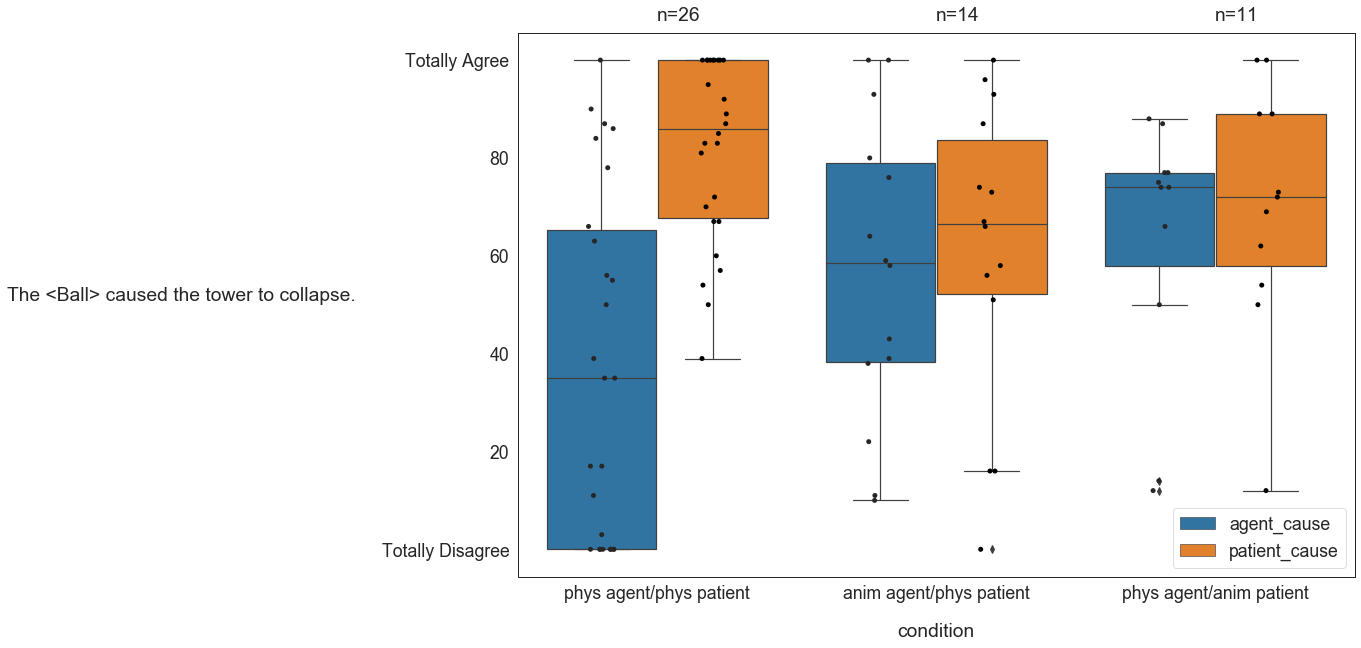

In [2]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(15,10))
xx = dat.melt(id_vars=['agent', 'patient', 'condition'], value_vars=['Q1', 'Q2'], var_name='ball', value_name='causal_rating')
xx['ball'] = xx.ball.str.replace('Q1', 'agent_cause')
xx['ball'] = xx.ball.str.replace('Q2', 'patient_cause')
g = sns.boxplot(x='condition', y='causal_rating', hue='ball', data=xx, ax=ax, order=ordering)
g = sns.stripplot(x='condition', y='causal_rating', hue='ball', data=xx, ax=ax, color='k', dodge=True, order=ordering)

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
ax.xaxis.labelpad = 20
ax.text(0, 108, "n="+str(len(dat.loc[dat.condition==ordering[0]])))
ax.text(1, 108, "n="+str(len(dat.loc[dat.condition==ordering[1]])))
ax.text(2, 108, "n="+str(len(dat.loc[dat.condition==ordering[2]])));
ax.set_ylabel("The <Ball> caused the tower to collapse.", rotation=0, labelpad=200)
ax.set_yticklabels(['0', 'Totally Disagree', '20', '40', '60', '80', 'Totally Agree']);
#fig.savefig('Figures/pilot.png')

# Counterfactual Ratings per Condition

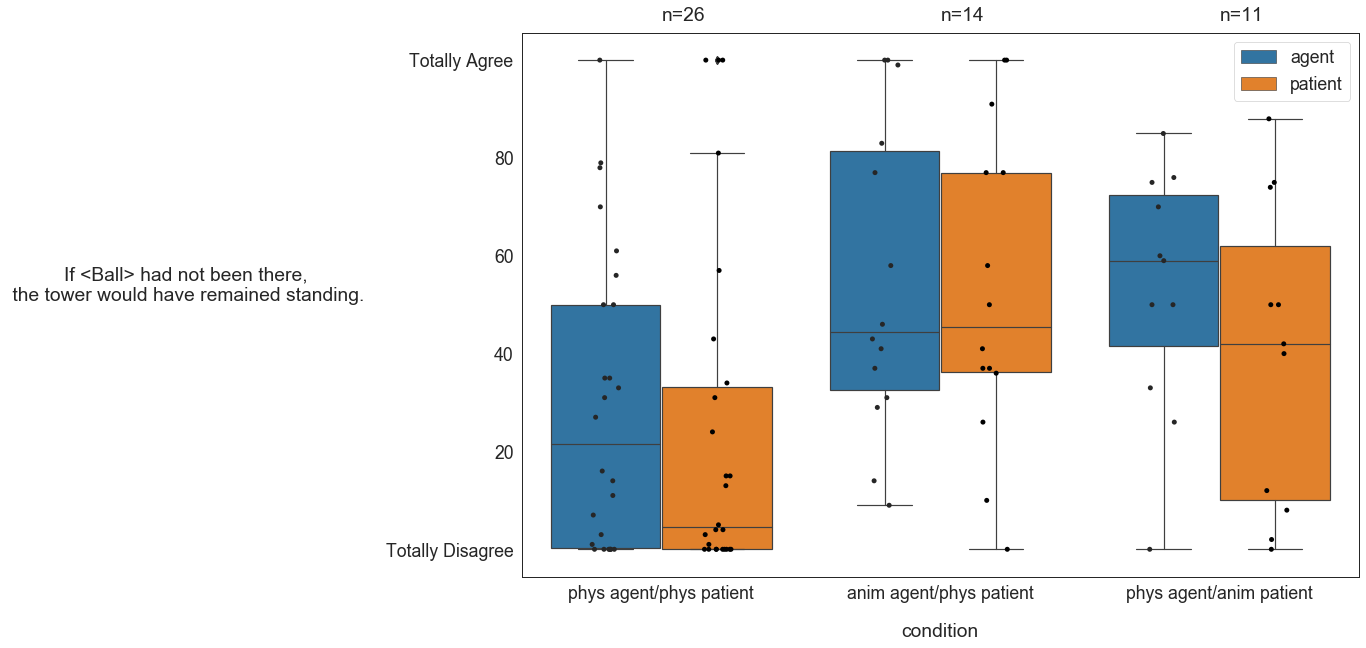

In [3]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(15,10))
xx = dat.melt(id_vars=['agent', 'patient', 'condition'], value_vars=['Q3', 'Q4'], var_name='ball', value_name='cf_rating')
xx['ball'] = xx.ball.str.replace('Q3', 'agent')
xx['ball'] = xx.ball.str.replace('Q4', 'patient')
g = sns.boxplot(x='condition', y='cf_rating', hue='ball', data=xx, ax=ax, order=ordering)
g = sns.stripplot(x='condition', y='cf_rating', hue='ball', data=xx, ax=ax, color='k', dodge=True, order=ordering)

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
ax.xaxis.labelpad = 20
ax.text(0, 108, "n="+str(len(dat.loc[dat.condition==ordering[0]])))
ax.text(1, 108, "n="+str(len(dat.loc[dat.condition==ordering[1]])))
ax.text(2, 108, "n="+str(len(dat.loc[dat.condition==ordering[2]]))
)

ax.set_ylabel("If <Ball> had not been there,\n the tower would have remained standing.", rotation=0, labelpad=200)
ax.set_yticklabels(['0', 'Totally Disagree', '20', '40', '60', '80', 'Totally Agree']);
#plt.savefig('Figures/pilot_cf.png', bbox_inches='tight')

# Causal x Counterfactual Ratings per Condition

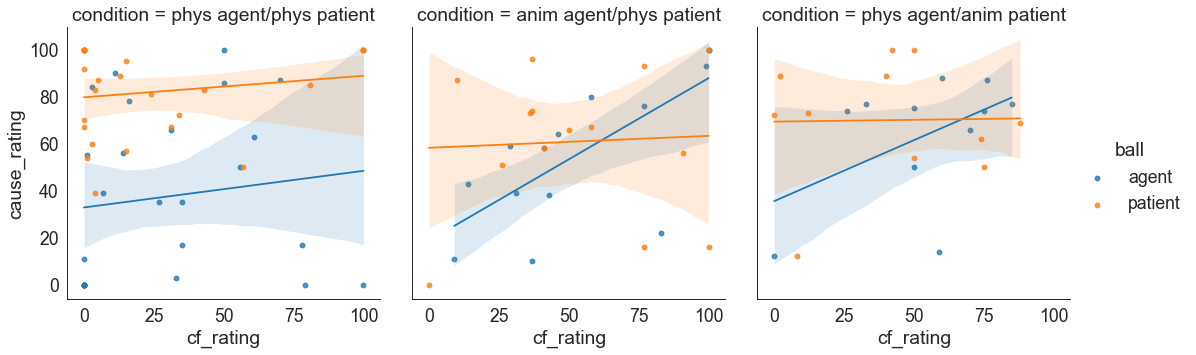

In [4]:
# Combining two long DFs
xx = dat.melt(id_vars=['agent', 'patient', 'condition'], value_vars=['Q1', 'Q2',], var_name='ball', value_name='cause_rating')
xx['ball'] = xx.ball.str.replace('Q1', 'agent')
xx['ball'] = xx.ball.str.replace('Q2', 'patient')
yy = dat.melt(id_vars=['agent', 'patient', 'condition'], value_vars=['Q3', 'Q4',], var_name='ball', value_name='cf_rating')
yy['ball'] = yy.ball.str.replace('Q3', 'agent')
yy['ball'] = yy.ball.str.replace('Q4', 'patient')
xx['cf_rating'] = yy.cf_rating

g = sns.lmplot(x='cf_rating', y='cause_rating', hue='ball', col='condition', data=xx)
#g.fig.savefig('Figures/cause_cf_pilot.png')